# Training a ConvNet PyTorch

In this notebook, you'll learn how to use the powerful PyTorch framework to specify a conv net architecture and train it on the CIFAR-10 dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

## What's this PyTorch business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, PyTorch (or TensorFlow, if you switch over to that notebook). 

Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn PyTorch?

If you've used Torch before, but are new to PyTorch, this tutorial might be of use: http://pytorch.org/tutorials/beginner/former_torchies_tutorial.html

Otherwise, this notebook will walk you through much of what you need to do to train models in Torch. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets

We load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [37]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True,
                          transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


For now, we're going to use a CPU-friendly datatype. Later, we'll switch to a datatype that will move all our computations to the GPU and measure the speedup.

In [3]:
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

## Example Model

### Some assorted tidbits

Let's start by looking at a simple model. First, note that PyTorch operates on Tensors, which are n-dimensional arrays functionally analogous to numpy's ndarrays, with the additional feature that they can be used for computations on GPUs.

We'll provide you with a Flatten function, which we explain here. Remember that our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input  data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in PyTorch -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up.  nn.Sequential is a container which applies each layer
one after the other.

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Cross-Entropy loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.


In [5]:
# Here's where we define the architecture of the model... 
simple_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(5408, 10), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
simple_model.type(dtype)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2) # lr sets the learning rate of the optimizer

PyTorch supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the PyTorch documentation and configuring your own model. 

Using the code provided above as guidance, and using the following PyTorch documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs

And finally, set up a **cross-entropy** loss function and the **RMSprop** learning rule.

In [6]:
fixed_model_base = nn.Sequential( # You fill this in!
                nn.Conv2d(3, 32, kernel_size=7, stride=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2, stride=2), # Maintain the dimension
                Flatten(), # Flatten the NxWxHxC to Nx(WHC) to feed through the affine layer
                nn.Linear(5408, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 10), # affine layer
            )

# Set the type of all data in this model to be FloatTensor
fixed_model = fixed_model_base.type(dtype)


To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [7]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(64, 3, 32, 32).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))       

True

### GPU!

Now, we're going to switch the dtype of the model and our data to the GPU-friendly tensors, and see what happens... everything is the same, except we are casting our model and input tensors as this new dtype instead of the old one.

If this returns false, or otherwise fails in a not-graceful way (i.e., with some error message), you may not have an NVIDIA GPU available on your machine. If you're running locally, we recommend you switch to Google Cloud and follow the instructions to set up a GPU there. If you're already on Google Cloud, something is wrong -- make sure you followed the instructions on how to request and use a GPU on your instance. If you did, post on Piazza or come to Office Hours so we can help you debug.

In [8]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

True

In [9]:
import copy
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base).type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

True

Run the following cell to evaluate the performance of the forward pass running on the CPU:

In [10]:
%%timeit 
ans = fixed_model(x_var)

100 loops, best of 3: 15.2 ms per loop


... and now the GPU:

In [11]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

1000 loops, best of 3: 742 µs per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use the GPU datatype for your model and your tensors: as a reminder that is *torch.cuda.FloatTensor* (in our notebook here as *gpu_dtype*)

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the simple_model we provided above).

Make sure you understand how each PyTorch function used below corresponds to what you implemented in your custom neural network implementation.

Note that because we are not resetting the weights anywhere below, if you run the cell multiple times, you are effectively training multiple epochs (so your performance should improve).

First, set up an RMSprop optimizer (using a 1e-3 learning rate) and a cross-entropy loss function:

In [12]:
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.RMSprop(fixed_model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
pass


In [13]:
# This sets the model in "training" mode. This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model_gpu.train()

# Load one batch at a time.
for t, (x, y) in enumerate(loader_train):
    x_var = Variable(x.type(gpu_dtype))
    y_var = Variable(y.type(gpu_dtype).long())

    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model_gpu(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
    if (t + 1) % print_every == 0:
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()

t = 100, loss = 2.2898
t = 200, loss = 2.3411
t = 300, loss = 2.3125
t = 400, loss = 2.2753
t = 500, loss = 2.3072
t = 600, loss = 2.3435
t = 700, loss = 2.3010


Now you've seen how the training process works in PyTorch. To save you writing boilerplate code, we're providing the following helper functions to help you train for multiple epochs and check the accuracy of your model:

In [14]:
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Check the accuracy of the model.

Let's see the train and check_accuracy code in action -- feel free to use these methods when evaluating the models you develop below.

You should get a training loss of around 1.2-1.4, and a validation accuracy of around 50-60%. As mentioned above, if you re-run the cells, you'll be training more epochs, so your performance will improve past these numbers.

But don't worry about getting these numbers better -- this was just practice before you tackle designing your own model.

In [15]:
torch.cuda.random.manual_seed(12345)
fixed_model_gpu.apply(reset)
train(fixed_model_gpu, loss_fn, optimizer, num_epochs=1)
check_accuracy(fixed_model_gpu, loader_val)

Starting epoch 1 / 1
t = 100, loss = 2.2925
t = 200, loss = 2.3011
t = 300, loss = 2.3085
t = 400, loss = 2.3127
t = 500, loss = 2.2967
t = 600, loss = 2.3012
t = 700, loss = 2.3108
Checking accuracy on validation set
Got 81 / 1000 correct (8.10)


### Don't forget the validation set!

And note that you can use the check_accuracy function to evaluate on either the test set or the validation set, by passing either **loader_test** or **loader_val** as the second argument to check_accuracy. You should not touch the test set until you have finished your architecture and hyperparameter tuning, and only run the test set once at the end to report a final value. 

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **>=70%** accuracy on the CIFAR-10 **validation** set. You can use the check_accuracy and train functions from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 70% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. 

Have fun and happy training!

** Inspired from this tutorial: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html**

More resources:
* https://github.com/prlz77/ResNeXt.pytorch/blob/master/train.py
* https://github.com/xternalz/WideResNet-pytorch/blob/master/train.py

### We experiment training with normalized images

In [47]:
# Image Normalization 
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dsets = {x: dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
         for x in ['train', 'val']}
dsets['test'] = dset.CIFAR10('./cs231n/datasets', train=False, download=True,
                          transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Load into mini-batches of 64. Shuffled.

In [49]:
NUM_TRAIN = 49000
NUM_VAL = 1000

dset_loaders = {}
dset_loaders['train'] = DataLoader(dsets['train'], batch_size=64, shuffle=True, sampler=ChunkSampler(NUM_TRAIN, 0))
dset_loaders['val'] = DataLoader(dsets['val'], batch_size=64, shuffle=True, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))
dset_loaders['test'] = DataLoader(dsets['test'], batch_size=64, shuffle=True)

### Visualize 5 images

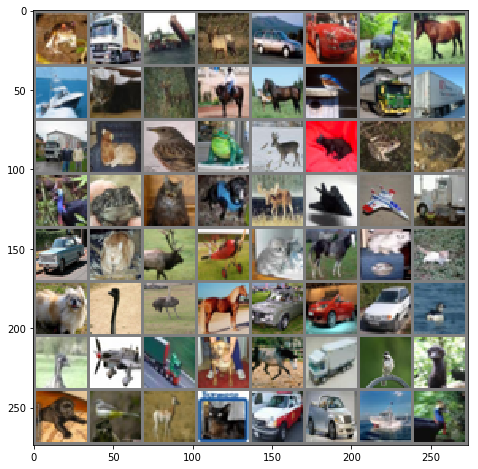

In [58]:
import torchvision

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dset_loaders['train'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [92]:
import time
import matplotlib.pyplot as plt
import copy

# Advanced Train Function
def train_adv(model, criterion, optimizer, lr_scheduler, num_epochs=1, plot=False):
    since = time.time() # Begin
    reset(model)
    
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Starting epoch %d out of %d" % (epoch + 1, num_epochs))
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                optimizer = lr_scheduler(optimizer, epoch) # Update the optimizer with a new learning rate
                model.train(True) # True = set to training mode
            else:
                model.train(False) # False = set to validation mode
            
            running_loss = 0.0
            running_corrects = 0
            losses = []
            accs = []
            num_samples = 0
            
            for t, (inputs, labels) in enumerate(dset_loaders[phase]):
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda()) # Convert to PyTorch Variables
                optimizer.zero_grad() # Initilize all gradients to be zero
                
                # Forward
                scores = model(inputs) 
                _, preds = torch.max(scores.data, 1) # Pick predicted labels according to columns
                loss = criterion(scores, labels)
                
                num_samples += preds.size(0)
                batch_loss = loss.data[0]
                batch_corr = torch.sum(preds == labels.data)
                batch_acc = batch_corr / preds.size(0)
                losses.append(batch_loss)
                accs.append(batch_acc)
                
                if (t + 1) % print_every == 0:
                    print('t = %d, loss = %.4f, acc = %.4f' % (t + 1, batch_loss, batch_acc))
                    
                # Train the model
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                running_loss += batch_loss * preds.size(0)
                running_corrects += batch_corr
            
            epoch_loss = running_loss / num_samples
            epoch_acc = running_corrects / num_samples
            
            print('{} : Epoch {}, Overall Loss: {:.4f} and Accuracy: {:.4f}'.format(phase, epoch+1, epoch_loss, epoch_acc))
            
            if plot and phase == "train":
                fig, ax = plt.subplots(figsize=(10, 5))
                plt.grid(True)

                line1, = ax.plot(losses, label='Losses')
                line2, = ax.plot(accs, label='Accuracy')

                ax.legend(loc='lower right')
                plt.title('Epoch {} Loss'.format(epoch+1))
                plt.xlabel('Minibatch Number')
                plt.show()
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print("Best So Far:", best_acc)
                best_model = copy.deepcopy(model) # Update the best model
        
        print()
    
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:4f}'.format(best_acc))
    return best_model

In [93]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=100):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [94]:
use_gpu = torch.cuda.is_available()

from models import *

net = ResNet18()

if use_gpu:
    net = net.cuda() # GPU

In [95]:
# From the paper
# We use SGD with a mini-batch size of 256. 
# The learning rate starts from 0.1 and is divided by 10 when the error plateaus. 
# and the models are trained for up to 60 × 104 iterations. We use a weight decay of 0.0001 and a momentum of 0.9.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, dampening=0, weight_decay=0.0005, nesterov=True)

In [ ]:
# Train
print_every = 100
best_net = train_adv(model=net, criterion=criterion, optimizer=optimizer, lr_scheduler=exp_lr_scheduler, num_epochs=300, plot=False)

Starting epoch 1 out of 300
----------
LR is set to 0.1
t = 100, loss = 1.5470, acc = 0.4844
t = 200, loss = 1.4892, acc = 0.4688
t = 300, loss = 1.5882, acc = 0.4062
t = 400, loss = 1.0952, acc = 0.6094
t = 500, loss = 1.2437, acc = 0.5312
t = 600, loss = 1.0034, acc = 0.6250
t = 700, loss = 1.0977, acc = 0.5938
train : Epoch 1, Overall Loss: 1.3568 and Accuracy: 0.5035
val : Epoch 1, Overall Loss: 1.0726 and Accuracy: 0.6370
Best So Far: 0.637

Starting epoch 2 out of 300
----------
t = 100, loss = 0.8554, acc = 0.6719
t = 200, loss = 0.8684, acc = 0.7344
t = 300, loss = 0.9957, acc = 0.6250
t = 400, loss = 0.7319, acc = 0.7500
t = 500, loss = 0.8308, acc = 0.6875
t = 600, loss = 0.8165, acc = 0.6562
t = 700, loss = 0.8608, acc = 0.6719
train : Epoch 2, Overall Loss: 0.8474 and Accuracy: 0.6997
val : Epoch 2, Overall Loss: 0.8714 and Accuracy: 0.7160
Best So Far: 0.716

Starting epoch 3 out of 300
----------
t = 100, loss = 0.6318, acc = 0.7969
t = 200, loss = 0.7790, acc = 0.7656
t 

t = 300, loss = 0.3587, acc = 0.8438
t = 400, loss = 0.3412, acc = 0.9062
t = 500, loss = 0.3133, acc = 0.8906
t = 600, loss = 0.2480, acc = 0.9375
t = 700, loss = 0.5673, acc = 0.8125
train : Epoch 20, Overall Loss: 0.3982 and Accuracy: 0.8589
val : Epoch 20, Overall Loss: 0.8285 and Accuracy: 0.7490

Starting epoch 21 out of 300
----------
t = 100, loss = 0.2627, acc = 0.9688
t = 200, loss = 0.2970, acc = 0.8906
t = 300, loss = 0.3496, acc = 0.8906
t = 400, loss = 0.3439, acc = 0.8750
t = 500, loss = 0.3318, acc = 0.9062
t = 600, loss = 0.3969, acc = 0.8281
t = 700, loss = 0.4673, acc = 0.8281
train : Epoch 21, Overall Loss: 0.3982 and Accuracy: 0.8615
val : Epoch 21, Overall Loss: 0.8521 and Accuracy: 0.7530

Starting epoch 22 out of 300
----------
t = 100, loss = 0.4039, acc = 0.8906
t = 200, loss = 0.2763, acc = 0.8750
t = 300, loss = 0.4900, acc = 0.8281
t = 400, loss = 0.2377, acc = 0.9375
t = 500, loss = 0.3290, acc = 0.8906
t = 600, loss = 0.4257, acc = 0.8281
t = 700, loss = 

val : Epoch 39, Overall Loss: 0.9519 and Accuracy: 0.7580

Starting epoch 40 out of 300
----------
t = 100, loss = 0.2995, acc = 0.8906
t = 200, loss = 0.3595, acc = 0.8281
t = 300, loss = 0.2747, acc = 0.8594
t = 400, loss = 0.4199, acc = 0.8906
t = 500, loss = 0.3753, acc = 0.8594
t = 600, loss = 0.2206, acc = 0.9219
t = 700, loss = 0.4569, acc = 0.8594
train : Epoch 40, Overall Loss: 0.3614 and Accuracy: 0.8748
val : Epoch 40, Overall Loss: 0.8094 and Accuracy: 0.7560

Starting epoch 41 out of 300
----------
t = 100, loss = 0.3426, acc = 0.8750
t = 200, loss = 0.3182, acc = 0.8594
t = 300, loss = 0.2997, acc = 0.8750
t = 400, loss = 0.2163, acc = 0.9375
t = 500, loss = 0.4178, acc = 0.8281
t = 600, loss = 0.3585, acc = 0.8906
t = 700, loss = 0.5597, acc = 0.8594
train : Epoch 41, Overall Loss: 0.3599 and Accuracy: 0.8750
val : Epoch 41, Overall Loss: 0.8228 and Accuracy: 0.7570

Starting epoch 42 out of 300
----------
t = 100, loss = 0.2496, acc = 0.8906
t = 200, loss = 0.3895, acc 

t = 600, loss = 0.4781, acc = 0.8750
t = 700, loss = 0.3734, acc = 0.8750
train : Epoch 59, Overall Loss: 0.3445 and Accuracy: 0.8801
val : Epoch 59, Overall Loss: 0.9069 and Accuracy: 0.7430

Starting epoch 60 out of 300
----------
t = 100, loss = 0.2767, acc = 0.8906
t = 200, loss = 0.2859, acc = 0.9062
t = 300, loss = 0.3329, acc = 0.8906
t = 400, loss = 0.1933, acc = 0.9062
t = 500, loss = 0.3020, acc = 0.9062
t = 600, loss = 0.3522, acc = 0.8906
t = 700, loss = 0.2792, acc = 0.8906
train : Epoch 60, Overall Loss: 0.3643 and Accuracy: 0.8734
val : Epoch 60, Overall Loss: 0.7738 and Accuracy: 0.7680

Starting epoch 61 out of 300
----------
t = 100, loss = 0.1942, acc = 0.9531
t = 200, loss = 0.3531, acc = 0.8906
t = 300, loss = 0.3291, acc = 0.8906
t = 400, loss = 0.3534, acc = 0.8906
t = 500, loss = 0.3998, acc = 0.8750
t = 600, loss = 0.3279, acc = 0.9062
t = 700, loss = 0.5930, acc = 0.8125
train : Epoch 61, Overall Loss: 0.3481 and Accuracy: 0.8784
val : Epoch 61, Overall Loss: 

t = 200, loss = 0.2694, acc = 0.9375
t = 300, loss = 0.3930, acc = 0.8281
t = 400, loss = 0.3323, acc = 0.9219
t = 500, loss = 0.2873, acc = 0.8594
t = 600, loss = 0.3107, acc = 0.9219
t = 700, loss = 0.2640, acc = 0.9062
train : Epoch 79, Overall Loss: 0.3380 and Accuracy: 0.8817
val : Epoch 79, Overall Loss: 0.7842 and Accuracy: 0.7850

Starting epoch 80 out of 300
----------
t = 100, loss = 0.2598, acc = 0.9062
t = 200, loss = 0.3486, acc = 0.8906
t = 300, loss = 0.3494, acc = 0.8906
t = 400, loss = 0.1818, acc = 0.9375
t = 500, loss = 0.3392, acc = 0.8750
t = 600, loss = 0.3215, acc = 0.8750
t = 700, loss = 0.3303, acc = 0.8906
train : Epoch 80, Overall Loss: 0.3316 and Accuracy: 0.8842
val : Epoch 80, Overall Loss: 0.9595 and Accuracy: 0.7520

Starting epoch 81 out of 300
----------
t = 100, loss = 0.4061, acc = 0.9062
t = 200, loss = 0.3552, acc = 0.8438
t = 300, loss = 0.3071, acc = 0.8750
t = 400, loss = 0.3354, acc = 0.8906
t = 500, loss = 0.3681, acc = 0.9062
t = 600, loss = 

train : Epoch 98, Overall Loss: 0.3352 and Accuracy: 0.8824
val : Epoch 98, Overall Loss: 0.7870 and Accuracy: 0.7680

Starting epoch 99 out of 300
----------
t = 100, loss = 0.2614, acc = 0.9219
t = 200, loss = 0.3712, acc = 0.9062
t = 300, loss = 0.2810, acc = 0.9062
t = 400, loss = 0.3031, acc = 0.8594
t = 500, loss = 0.2949, acc = 0.8906
t = 600, loss = 0.3293, acc = 0.8906
t = 700, loss = 0.4299, acc = 0.8750
train : Epoch 99, Overall Loss: 0.3511 and Accuracy: 0.8768
val : Epoch 99, Overall Loss: 0.8286 and Accuracy: 0.7700

Starting epoch 100 out of 300
----------
t = 100, loss = 0.1925, acc = 0.9531
t = 200, loss = 0.3645, acc = 0.8750
t = 300, loss = 0.2414, acc = 0.9531
t = 400, loss = 0.1747, acc = 0.9531
t = 500, loss = 0.2941, acc = 0.9062
t = 600, loss = 0.5414, acc = 0.8438
t = 700, loss = 0.4368, acc = 0.8750
train : Epoch 100, Overall Loss: 0.3390 and Accuracy: 0.8821
val : Epoch 100, Overall Loss: 0.8164 and Accuracy: 0.7780

Starting epoch 101 out of 300
----------
L

t = 100, loss = 0.0018, acc = 1.0000
t = 200, loss = 0.0020, acc = 1.0000
t = 300, loss = 0.0025, acc = 1.0000
t = 400, loss = 0.0016, acc = 1.0000
t = 500, loss = 0.0022, acc = 1.0000
t = 600, loss = 0.0015, acc = 1.0000
t = 700, loss = 0.0018, acc = 1.0000
train : Epoch 118, Overall Loss: 0.0018 and Accuracy: 1.0000
val : Epoch 118, Overall Loss: 0.4733 and Accuracy: 0.8710

Starting epoch 119 out of 300
----------
t = 100, loss = 0.0017, acc = 1.0000
t = 200, loss = 0.0019, acc = 1.0000
t = 300, loss = 0.0024, acc = 1.0000
t = 400, loss = 0.0016, acc = 1.0000
t = 500, loss = 0.0021, acc = 1.0000
t = 600, loss = 0.0015, acc = 1.0000
t = 700, loss = 0.0018, acc = 1.0000
train : Epoch 119, Overall Loss: 0.0017 and Accuracy: 1.0000
val : Epoch 119, Overall Loss: 0.4722 and Accuracy: 0.8710

Starting epoch 120 out of 300
----------
t = 100, loss = 0.0015, acc = 1.0000
t = 200, loss = 0.0018, acc = 1.0000
t = 300, loss = 0.0023, acc = 1.0000
t = 400, loss = 0.0015, acc = 1.0000
t = 500, l

t = 700, loss = 0.0011, acc = 1.0000
train : Epoch 137, Overall Loss: 0.0009 and Accuracy: 1.0000
val : Epoch 137, Overall Loss: 0.4837 and Accuracy: 0.8590

Starting epoch 138 out of 300
----------
t = 100, loss = 0.0008, acc = 1.0000
t = 200, loss = 0.0010, acc = 1.0000
t = 300, loss = 0.0012, acc = 1.0000
t = 400, loss = 0.0009, acc = 1.0000
t = 500, loss = 0.0009, acc = 1.0000
t = 600, loss = 0.0008, acc = 1.0000
t = 700, loss = 0.0010, acc = 1.0000
train : Epoch 138, Overall Loss: 0.0009 and Accuracy: 1.0000
val : Epoch 138, Overall Loss: 0.4841 and Accuracy: 0.8600

Starting epoch 139 out of 300
----------
t = 100, loss = 0.0008, acc = 1.0000
t = 200, loss = 0.0010, acc = 1.0000
t = 300, loss = 0.0012, acc = 1.0000
t = 400, loss = 0.0009, acc = 1.0000
t = 500, loss = 0.0009, acc = 1.0000
t = 600, loss = 0.0008, acc = 1.0000
t = 700, loss = 0.0010, acc = 1.0000
train : Epoch 139, Overall Loss: 0.0009 and Accuracy: 1.0000
val : Epoch 139, Overall Loss: 0.4836 and Accuracy: 0.8630



t = 100, loss = 0.0007, acc = 1.0000
t = 200, loss = 0.0008, acc = 1.0000
t = 300, loss = 0.0009, acc = 1.0000
t = 400, loss = 0.0007, acc = 1.0000
t = 500, loss = 0.0007, acc = 1.0000
t = 600, loss = 0.0007, acc = 1.0000
t = 700, loss = 0.0009, acc = 1.0000
train : Epoch 157, Overall Loss: 0.0008 and Accuracy: 1.0000
val : Epoch 157, Overall Loss: 0.4940 and Accuracy: 0.8640

Starting epoch 158 out of 300
----------
t = 100, loss = 0.0007, acc = 1.0000
t = 200, loss = 0.0008, acc = 1.0000
t = 300, loss = 0.0009, acc = 1.0000
t = 400, loss = 0.0007, acc = 1.0000
t = 500, loss = 0.0007, acc = 1.0000
t = 600, loss = 0.0007, acc = 1.0000
t = 700, loss = 0.0009, acc = 1.0000
train : Epoch 158, Overall Loss: 0.0008 and Accuracy: 1.0000
val : Epoch 158, Overall Loss: 0.4993 and Accuracy: 0.8640

Starting epoch 159 out of 300
----------
t = 100, loss = 0.0006, acc = 1.0000
t = 200, loss = 0.0008, acc = 1.0000
t = 300, loss = 0.0009, acc = 1.0000
t = 400, loss = 0.0007, acc = 1.0000
t = 500, l

t = 700, loss = 0.1101, acc = 0.9531
train : Epoch 176, Overall Loss: 0.1455 and Accuracy: 0.9473
val : Epoch 176, Overall Loss: 0.9946 and Accuracy: 0.7660

Starting epoch 177 out of 300
----------
t = 100, loss = 0.1402, acc = 0.9531
t = 200, loss = 0.0788, acc = 0.9688
t = 300, loss = 0.0845, acc = 0.9688
t = 400, loss = 0.1091, acc = 0.9844
t = 500, loss = 0.0966, acc = 0.9688
t = 600, loss = 0.0931, acc = 0.9688
t = 700, loss = 0.0878, acc = 0.9844
train : Epoch 177, Overall Loss: 0.1194 and Accuracy: 0.9577
val : Epoch 177, Overall Loss: 1.0548 and Accuracy: 0.7590

Starting epoch 178 out of 300
----------
t = 100, loss = 0.1264, acc = 0.9688
t = 200, loss = 0.2071, acc = 0.9062
t = 300, loss = 0.3003, acc = 0.8906
t = 400, loss = 0.1017, acc = 0.9688
t = 500, loss = 0.2162, acc = 0.9375
t = 600, loss = 0.1890, acc = 0.9062
t = 700, loss = 0.0979, acc = 0.9844
train : Epoch 178, Overall Loss: 0.1148 and Accuracy: 0.9593
val : Epoch 178, Overall Loss: 1.0200 and Accuracy: 0.7560



### Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

This is ResNet18 with LR = 0.1 without decay.

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model).  This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
correct = 0
total = 0
best_net.eval()

for inputs, labels in dset_loaders['test']: # Apply to normalized test images
    inputs = Variable(inputs.cuda(), volatile=True)
    outputs = best_net(inputs)
    _, predicted = torch.max(outputs.data.cpu(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the %d test images: %f percent' % (total, 100 * correct / total))

## Going further with PyTorch

The next assignment will make heavy use of PyTorch. You might also find it useful for your projects. 

Here's a nice tutorial by Justin Johnson that shows off some of PyTorch's features, like dynamic graphs and custom NN modules: http://pytorch.org/tutorials/beginner/pytorch_with_examples.html

If you're interested in reinforcement learning for your final project, this is a good (more advanced) DQN tutorial in PyTorch: http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html